In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
#need to everything in one circuit for it to plot

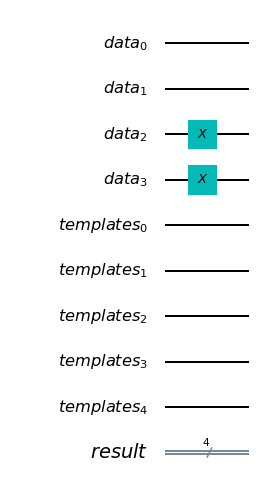

In [2]:
#initilization

#data and templates are all in binary form and we compare bit by bit
#define data register. Completely arbitrary, n is the number of qubits 
n=4
nanc=1
a=n+nanc
data = QuantumRegister(n,'data')
templates=QuantumRegister(a,'templates')
result=ClassicalRegister(n,'result')
search_Circuit=QuantumCircuit(data,templates,result)
#anc=QuantumRegister(nanc)
#the last qubit is the ancilla
#templates= QuantumRegister(a,'templates')
#data is 0011 
#search_Circuit=QuantumCircuit(data,templates)
search_Circuit.x(data[3])
search_Circuit.x(data[2])
qubits=search_Circuit.qubits
search_Circuit.draw(output="mpl")
#test=QuantumRegister
#print (QuantumRegister.name)

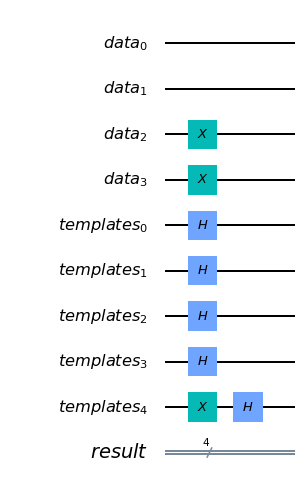

In [3]:
#Grover's Gate
#in order to search through n qubit, you need n+1 qubits
#grover_circuit = QuantumCircuit(templates)
#search qubits are initialised to 0 while the ancilla is initialised to 1
search_Circuit.x(templates[n])
#Hadmard gate is applied to all qubits
#for qubit in range(na):
 #   grover_circuit.h(qubit)
search_Circuit.h(templates[0:a]) 
search_Circuit.draw(output="mpl")

In [4]:
#unfortunately qiskit does not have ccccx gate so we have to define
#This is good because we dont have to put in number of qubits by hand
from qiskit.circuit.library.standard_gates import XGate,ZGate
def controlx(n):
    cx_gate = XGate().control(n)
    return cx_gate
def controlz(n):
    cz_gate = ZGate().control(n)
    return cz_gate

In [5]:
#templace matching oracle
#data bit match with template bit
#cx: is a classical AND gate, the result is on the second qubit.  ,templates,data
def template_matching_oracle(qc,ndata):
    '''
    inputregister is the superposition of templates 
    data is what we are comparing with
    we are comparing bit by bit, and only when all the comparison is positive we should have 1 in the result register
    #qubits = circuit.qubits
    #cr=ClassicalRegister(nqubits)
    #the two registers should have the same number of qubits
    '''
    qubits=qc.qubits
    #nqubits = len(templates)-1
    #qc=QuantumCircuit(templates,data)
    for qubit in range(ndata):
        #comparing data with templates qubit by qubit, first is the controll bit
        qc.cx(qubit, qubit+ndata)
        #cx gives a 0 if they match. so x-gates are needed 
        qc.x(qubit+ndata)
    '''
    now is the magic: ancilla qubit which is in the |-> state, with a cccc-x, would if and only if
    adopt a - sign when all bits match
    shame here need to manually change how many control with regard to how many qubits in the template register
    '''
    #qcmin=QuantumCircuit(templates)
    #unfortunately we need to hardcode the control gate in
    cx_gate=controlx(ndata)
    qc.append(cx_gate,[ndata,ndata+1,ndata+2,ndata+3,ndata+4])
    #qc.ccccx(templates[0:nqubits],ancilla)
    #reverse the previous processes to restore the template register
    for qubit in range(ndata):
        qc.x(qubit+ndata)
        qc.cx(qubit, qubit+ndata)
    #reverse the ancilla bit
    qc.h(-1)
    #return (qc)
        

In [6]:
#test oracle
'''
oracle_circuit=QuantumCircuit(templates,data)
oracle_circuit=template_matching_oracle(templates,data)
oracle_circuit.draw(output='mpl')
template_matching_oracle(search_Circuit,n)
search_Circuit.draw(output="mpl")'''

'\noracle_circuit=QuantumCircuit(templates,data)\noracle_circuit=template_matching_oracle(templates,data)\noracle_circuit.draw(output=\'mpl\')\ntemplate_matching_oracle(search_Circuit,n)\nsearch_Circuit.draw(output="mpl")'

2|ψihψ| −IN = H
⊗n
(2|0ih0| −IN)H
⊗n
,
where |ψi is the uniform superposition of states and IN is
the N dimensional identity matrix. As 2|ψihψ| −IN operates
a reflection about the |ψi, 2|0ih0| − IN operates a reflection
about the |0i. It turns out that Grover diffusion can be implemented on a quantum circuit with a phase shift operator that
negates all the states except for |0i sandwiched between H
⊗n
gates (see Section III for the implementation). More detailed
explanations can be found in Nielsen and Chuang [17].

In [7]:
#diffusion operator
def DiffOpe(qc,ndata):
    #nqubit = len(templates)-1
    #qc=QuantumCircuit(templates)
    #the hadmard  
    controlqubits=ndata-1
    cz_gate=controlz(controlqubits)
    for qubit in range(ndata):
        qc.h(ndata+qubit)
        qc.x(ndata+qubit)
    #the phase change, again, we need to hardcode it now
    qc.append(cz_gate,[ndata,ndata+1,ndata+2,ndata+3])
    #reverse the process to restore the register
    for qubit in range(ndata):
        qc.x(ndata+qubit)
        qc.h(ndata+qubit)

    #return (qc)
        
    


In [8]:
#test diffusion
'''oracle_circuit=DiffOpe(templates)
oracle_circuit.draw(output='mpl')
DiffOpe(search_Circuit,n)
search_Circuit.draw(output="mpl")'''

'oracle_circuit=DiffOpe(templates)\noracle_circuit.draw(output=\'mpl\')\nDiffOpe(search_Circuit,n)\nsearch_Circuit.draw(output="mpl")'

In [9]:
#calculating times need to aplly Grover's gate
#when we only have one match
''' nt=1 indication only one template
nt=0 indication we dont know how many template
if nt==1:
'''
import numpy as np
kt=float(np.pi/4 * np.sqrt(2**n))
kt=np.floor(kt)
print (kt)

3.0


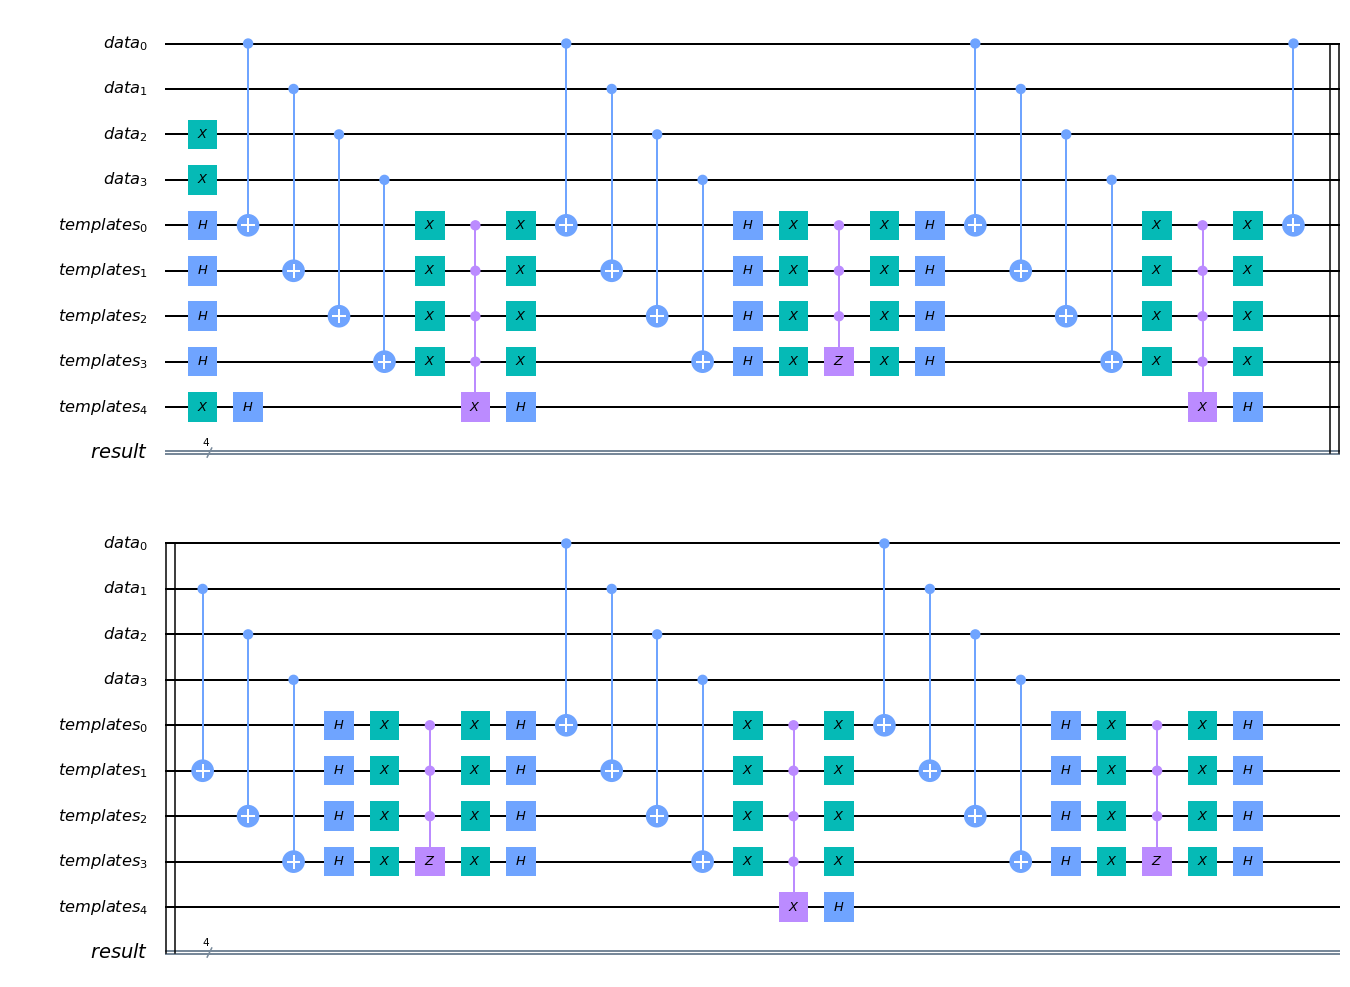

In [10]:
#search_circuit=QuantumCircuit(templates,data)
for i in range(int(kt)):
    template_matching_oracle(search_Circuit,n)
    DiffOpe(search_Circuit,n)
   # print (i)
    
search_Circuit.draw(output='mpl')


    
    

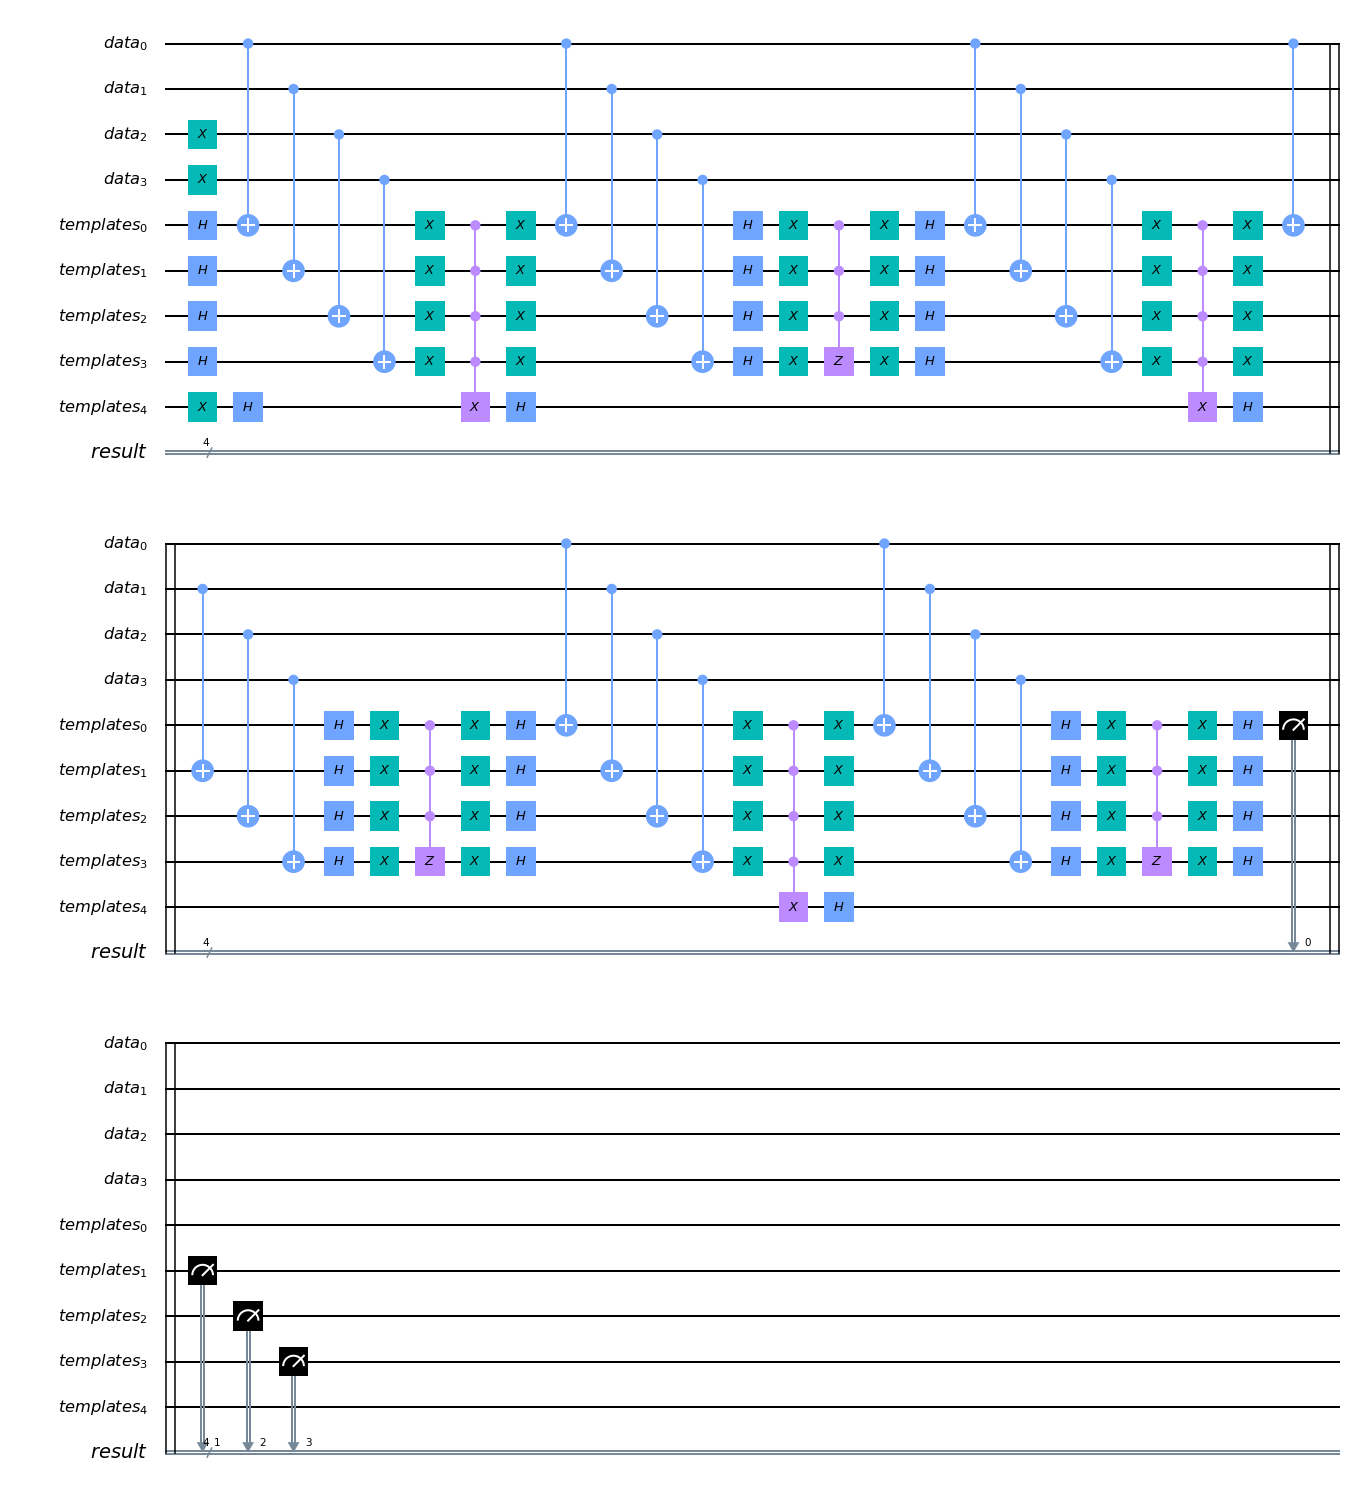

In [11]:
#measurement
for qubit in range(n):
    search_Circuit.measure(templates[qubit],result[qubit])
search_Circuit.draw(output='mpl')

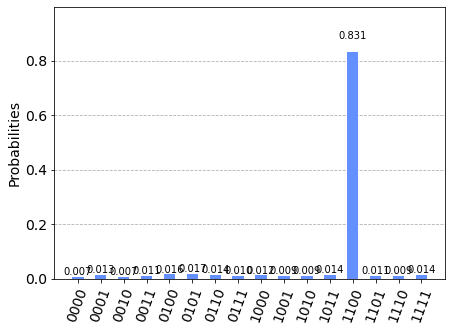

In [12]:
#experiment with the simulator
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(search_Circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [13]:
#quantum phase estimation

    #inverse QFT
    def qft_dagger(circ, n):
        """n-qubit QFTdagger the first n qubits in circ"""
        # Don't forget the Swaps!
        for qubit in range(n//2):
            circ.swap(qubit, n-qubit-1)
        for j in range(n):
            for m in range(j):
                circ.cu1(-math.pi/float(2**(j-m)), m, j)
            circ.h(j)
        #phase estimation

IndentationError: unexpected indent (<ipython-input-13-1f0894a28790>, line 4)